In [5]:
import pickle
import spacy

In [6]:
%load_ext autoreload
%autoreload 2
import spacy
import scispacy
from scispacy.linking import EntityLinker
import en_core_sci_lg
from scify.nlp import *
from scify.utils.GNBR_preprocessing import get_data_and_distributions
#from spacy.language import Language


In [108]:
text = "Spinal and bulbar muscular atrophy (SBMA) is an inherited motor neuron disease caused by the expansion of a polyglutamine tract within the androgen receptor (AR). SBMA can be caused by this easily."

In [105]:
from scispacy.abbreviation import AbbreviationDetector
from spacy.pipeline import merge_entities
from scispacy.linking import EntityLinker

abbreviation_pipe = AbbreviationDetector(nlp)
nlp = spacy.load("en_core_sci_lg")

nlp.add_pipe(abbreviation_pipe)
nlp.add_pipe(merge_entities)
#nlp.add_pipe(linker_umls)

In [109]:
#linker_umls = EntityLinker(resolve_abbreviations=True, name="umls")
nlp.add_pipe(linker_umls)

ValueError: [E007] 'EntityLinker' already exists in pipeline. Existing names: ['tagger', 'parser', 'ner', 'AbbreviationDetector', 'merge_entities', 'EntityLinker']

In [266]:
from textacy.corpus import Corpus

corp = Corpus(nlp).load(nlp, "../data/experiments/pubmed_20n1015_annotated_756")

#https://github.com/explosion/spaCy/issues/860
#Doc.set_extension("annotated", default=None)
#doc = nlp(text)

In [267]:
from scify.consts import labels
for label in labels:
    nlp.vocab.strings.add(label)

In [259]:
#Doc.set_extension("annotated", default=False, force=False)
#Span.set_extension('annotated', default=[], force=True)
#Token.set_extension('annotated', default=[], force=False)
#corp[2].ents[1].set_extension('annotated', default=False, force=False)

In [279]:
def reannotate(doc:Doc):    
    """Takes deserialized doc.user_data with the doc's custom_attributes data and sets the ._.annotated attribute again on the entity so it's easier to process later"""
    #strangely two entries with different spans for some entities in user_data as in ._.annotated although user_data is generated by ._.annotated 
    for k,v in doc.user_data.items():
        for ent in doc.ents:
            #print(k, v, k[2])
            if ent.start_char == k[2]:
                #print(type(v), v)
                #converting to list to be consistent with merge_docs and other notebooks ._.annotated
                ent._.annotated = list(v)# if type(v) == tuple else []
                

In [278]:
def get_label_candidates_from_entity(ent: Span)->List:
    """aggregates labels from possibly multiple NER models (bc5, bionlpa...)"""
    return [cand["label"] for cand in ent._.annotated]

In [283]:
from scify.nlp import rgetattr, rsetattr
[get_label_candidates_from_entity(ent) for ent in corp[8].ents if len(ent._.annotated)]

[['MULTI-TISSUE_STRUCTURE'],
 ['ORGANISM'],
 ['ORGANISM'],
 ['ORGANISM'],
 ['DISEASE'],
 ['ORGANISM'],
 ['DISEASE'],
 ['TISSUE'],
 ['PATHOLOGICAL_FORMATION'],
 ['ORGANISM'],
 ['DISEASE'],
 ['ORGANISM'],
 ['DISEASE'],
 ['DISEASE'],
 ['TISSUE'],
 ['ORGANISM'],
 ['DISEASE'],
 ['MULTI-TISSUE_STRUCTURE'],
 ['ORGANISM']]

In [150]:
#nlp.vocab, "spacy.vocab.Vocab at 0x232d1a54"

(<spacy.vocab.Vocab at 0x1cfdcd940>, 'spacy.vocab.Vocab at 0x232d1a54')

In [ ]:
[ent.start for ent in doc.ents],[token.i for token in doc if (token.ent_iob == 2 or token.ent_iob == 0)]


In [ ]:
[token.i for token in doc[:25] if token.ent_iob == 3],[token.i for token in doc[:25] if token.ent_iob != 2]

In [ ]:
#https://stackoverflow.com/questions/51412095/spacy-save-custom-pipeline

In [ ]:
nlp.meta

In [ ]:
from itertools import product

[* product(["Yolo", "Fredo", "checko"], ["fatty", "fagg"])]
tokens_lookup = {tok.text:tok for tok in doc}

In [285]:
from scify.networks import get_edges
from scify.nlp import *

In [123]:
import networkx as nx

from scify.networks import get_edges
from networkx.drawing.nx_agraph import graphviz_layout, 
import matplotlib.pyplot as plt

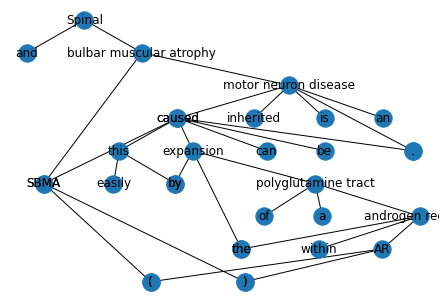

In [297]:
# write dot file to use with graphviz
# run "dot -Tpng test.dot >test.png"


In [298]:
#doc[14].ent_iob
visualise_doc(doc, compact=True)

In [311]:
[token for token in doc][2]

bulbar muscular atrophy

In [314]:
from scify.networks import get_sdp_path

In [315]:
get_sdp_path(doc, 2, 16, )

[bulbar muscular atrophy,
 motor neuron disease,
 caused,
 expansion,
 polyglutamine tract]

In [313]:
nx.shortest_path(G, doc[2], doc[16])#[0]._.annotated

[bulbar muscular atrophy,
 motor neuron disease,
 caused,
 expansion,
 polyglutamine tract]

In [22]:
def get_ent_from_token(token, doc):
    return [ent for ent in doc.ents if ent.start_char <= token.idx <= ent.end_char]

In [ ]:
#valid pattern
construct_pattern('|appos|START_ENTITY sensitivity|nmod|END_ENTITY') or []

In [ ]:
#invalid pattern
construct_pattern('sensitivity|nmod|END_ENTITY sensitivity|appos|START_ENTITY')

In [ ]:
from scify.networks import get_edges

In [ ]:
def get_shortest_dep_path(ent_a, ent_b, doc:Doc, graph=False):
    if not graph:
        G = nx.Graph(get_edges(doc))
    

    #networkx

def pattern_from_shortest_dep_path():
    5
    
def extract_pattern_between_entities(doc, ent_a, ent_b):
    4
    
